In [1]:

from sklearn.datasets import load_files
import numpy as np

train_dir = '../input/fruits/Fruits_1/Training'
test_dir = '../input/fruits/Fruits_1/Test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_train, y_train,target_labels = load_dataset(train_dir)
x_test, y_test,_ = load_dataset(test_dir)
print('Loading complete!')

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])

Loading complete!
Training set size :  21168
Testing set size :  7115


In [2]:
target_labels

array(['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1',
       'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith',
       'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3',
       'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2',
       'Banana', 'Banana Lady Finger', 'Banana Red', 'Cherry 1',
       'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red',
       'Cherry Wax Yellow', 'Grape Blue', 'Grape Pink', 'Grape White',
       'Grape White 2', 'Grape White 3', 'Grape White 4',
       'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Lychee', 'Mango',
       'Mango Red', 'Orange', 'Pineapple', 'Pineapple Mini', 'Raspberry',
       'Redcurrant', 'Strawberry', 'Strawberry Wedge'], dtype='<U19')

In [3]:

no_of_classes = len(np.unique(y_train))
no_of_classes

41

In [4]:
print(y_train[0:10])


[14 17 37 31 11 22 38  3  5 18]


In [5]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,no_of_classes)
y_test = np_utils.to_categorical(y_test,no_of_classes)
y_train[0]

Using TensorFlow backend.


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [6]:
x_test,x_valid = x_test[3500:],x_test[:3500]
y_test,y_valid = y_test[3500:],y_test[:3500]
print('Vaildation X : ',x_valid.shape)
print('Vaildation y :',y_valid.shape)
print('Test X : ',x_test.shape)
print('Test y : ',y_test.shape)

Vaildation X :  (3500,)
Vaildation y : (3500, 41)
Test X :  (3615,)
Test y :  (3615, 41)


In [7]:
x_train[0]

'../input/fruits/Fruits_1/Training/Banana Lady Finger/r_4_100.jpg'

In [8]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_valid = np.array(convert_image_to_array(x_valid))
print('Validation set shape : ',x_valid.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

print('1st training image shape ',x_train[0].shape)

Training set shape :  (21168, 100, 100, 3)
Validation set shape :  (3500, 100, 100, 3)
Test set shape :  (3615, 100, 100, 3)
1st training image shape  (100, 100, 3)


In [9]:
x_train/=255
x_valid/=255
x_test/=255

In [10]:
x_train[0].shape

(100, 100, 3)

In [11]:
from keras.applications.resnet_v2 import ResNet50V2
model=ResNet50V2(include_top=True, weights=None, input_tensor=None, input_shape=(100,100,3),classes=41)
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 52, 52, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [12]:
from keras import backend as K
def recall(y_true, y_pred):
     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
     recall = true_positives / (possible_positives + K.epsilon())
     return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
model.compile(loss='categorical_crossentropy',
               optimizer='nadam',
              metrics=['accuracy',recall,precision])
print('Compiled!')

Compiled!


In [13]:
num_train_samples = len(x_train)
num_val_samples = len(x_valid)
train_batch_size = 10
val_batch_size = 10
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
print(train_steps)

print(val_steps)

2117.0
350.0


In [14]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K

tf.compat.v2.random.set_seed
tf.random.uniform([1], seed=1)
checkpointer = ModelCheckpoint(filepath = 'cnn_from_scratch_fruits.hdf5',  verbose = 1, save_best_only = True,mode='max',monitor='val_accuracy')

train_image_generator = ImageDataGenerator(rotation_range=45,width_shift_range=.15,height_shift_range=.15, zoom_range=0.3)
train_data_gen = train_image_generator.flow(x_train,y_train)






history=model.fit(train_data_gen,steps_per_epoch=500,epochs=10,validation_data=(x_valid,y_valid),
                 
        callbacks = [checkpointer],
                    verbose=1,shuffle=True)

Epoch 1/10
500/500 [==============================] - 109s 217ms/step - loss: 0.8792 - accuracy: 0.7309 - recall: 0.6700 - precision: 0.7774 - val_loss: 1.2898 - val_accuracy: 0.6283 - val_recall: 0.6081 - val_precision: 0.6544

Epoch 00001: val_accuracy improved from -inf to 0.62829, saving model to cnn_from_scratch_fruits.hdf5
Epoch 2/10
500/500 [==============================] - 80s 161ms/step - loss: 0.2707 - accuracy: 0.9117 - recall: 0.9028 - precision: 0.9213 - val_loss: 3.9539 - val_accuracy: 0.4271 - val_recall: 0.4085 - val_precision: 0.4534

Epoch 00002: val_accuracy did not improve from 0.62829
Epoch 3/10
500/500 [==============================] - 78s 157ms/step - loss: 0.1788 - accuracy: 0.9412 - recall: 0.9370 - precision: 0.9455 - val_loss: 2.2105 - val_accuracy: 0.6109 - val_recall: 0.5989 - val_precision: 0.6303

Epoch 00003: val_accuracy did not improve from 0.62829
Epoch 4/10
500/500 [==============================] - 79s 158ms/step - loss: 0.1290 - accuracy: 0.9587 

In [15]:
model.load_weights('cnn_from_scratch_fruits.hdf5')

In [16]:

score = model.evaluate(x_test, y_test, verbose=2)
print('\n', 'Test accuracy:', score[1])



 Test accuracy: 0.9687413573265076


In [17]:
preds=np.round(model.predict(x_test),0)
print("Rounded test_labels",preds)

Rounded test_labels [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


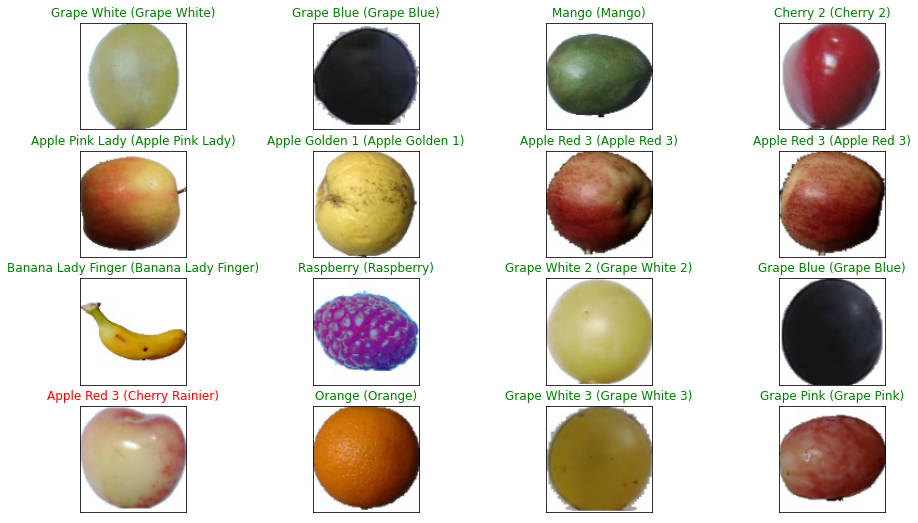

In [18]:
# Let's visualize test prediction.
import matplotlib.pyplot as plt

y_pred = model.predict(x_test)

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

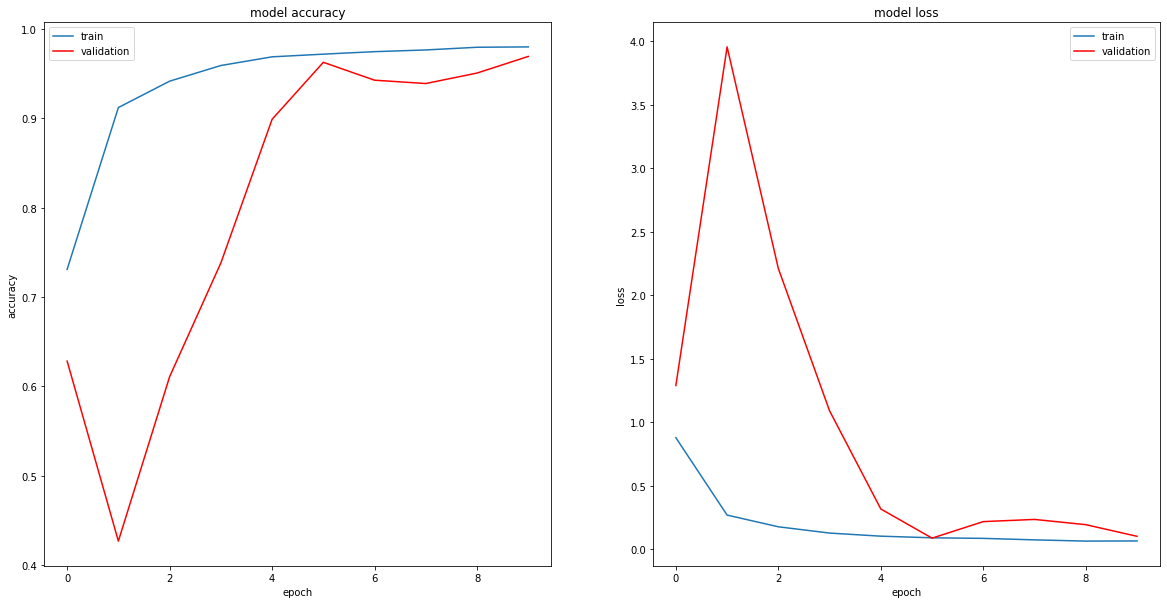

In [27]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,10))
   
 # summarize history for accuracy  
   
plt.subplot(121)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'],color='red')  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(122)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'],color='red')  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper right')  
plt.show()

In [20]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(
    y_test.argmax(axis=1), preds.argmax(axis=1))
cm

array([[ 89,   0,   0, ...,   0,   0,   0],
       [  0,  52,   0, ...,   0,   0,   0],
       [  0,   0,  86, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  74,   0,   0],
       [  0,   0,   0, ...,   0,  88,   0],
       [  0,   0,   0, ...,   0,   0, 131]])

In [21]:
cm.shape

(41, 41)

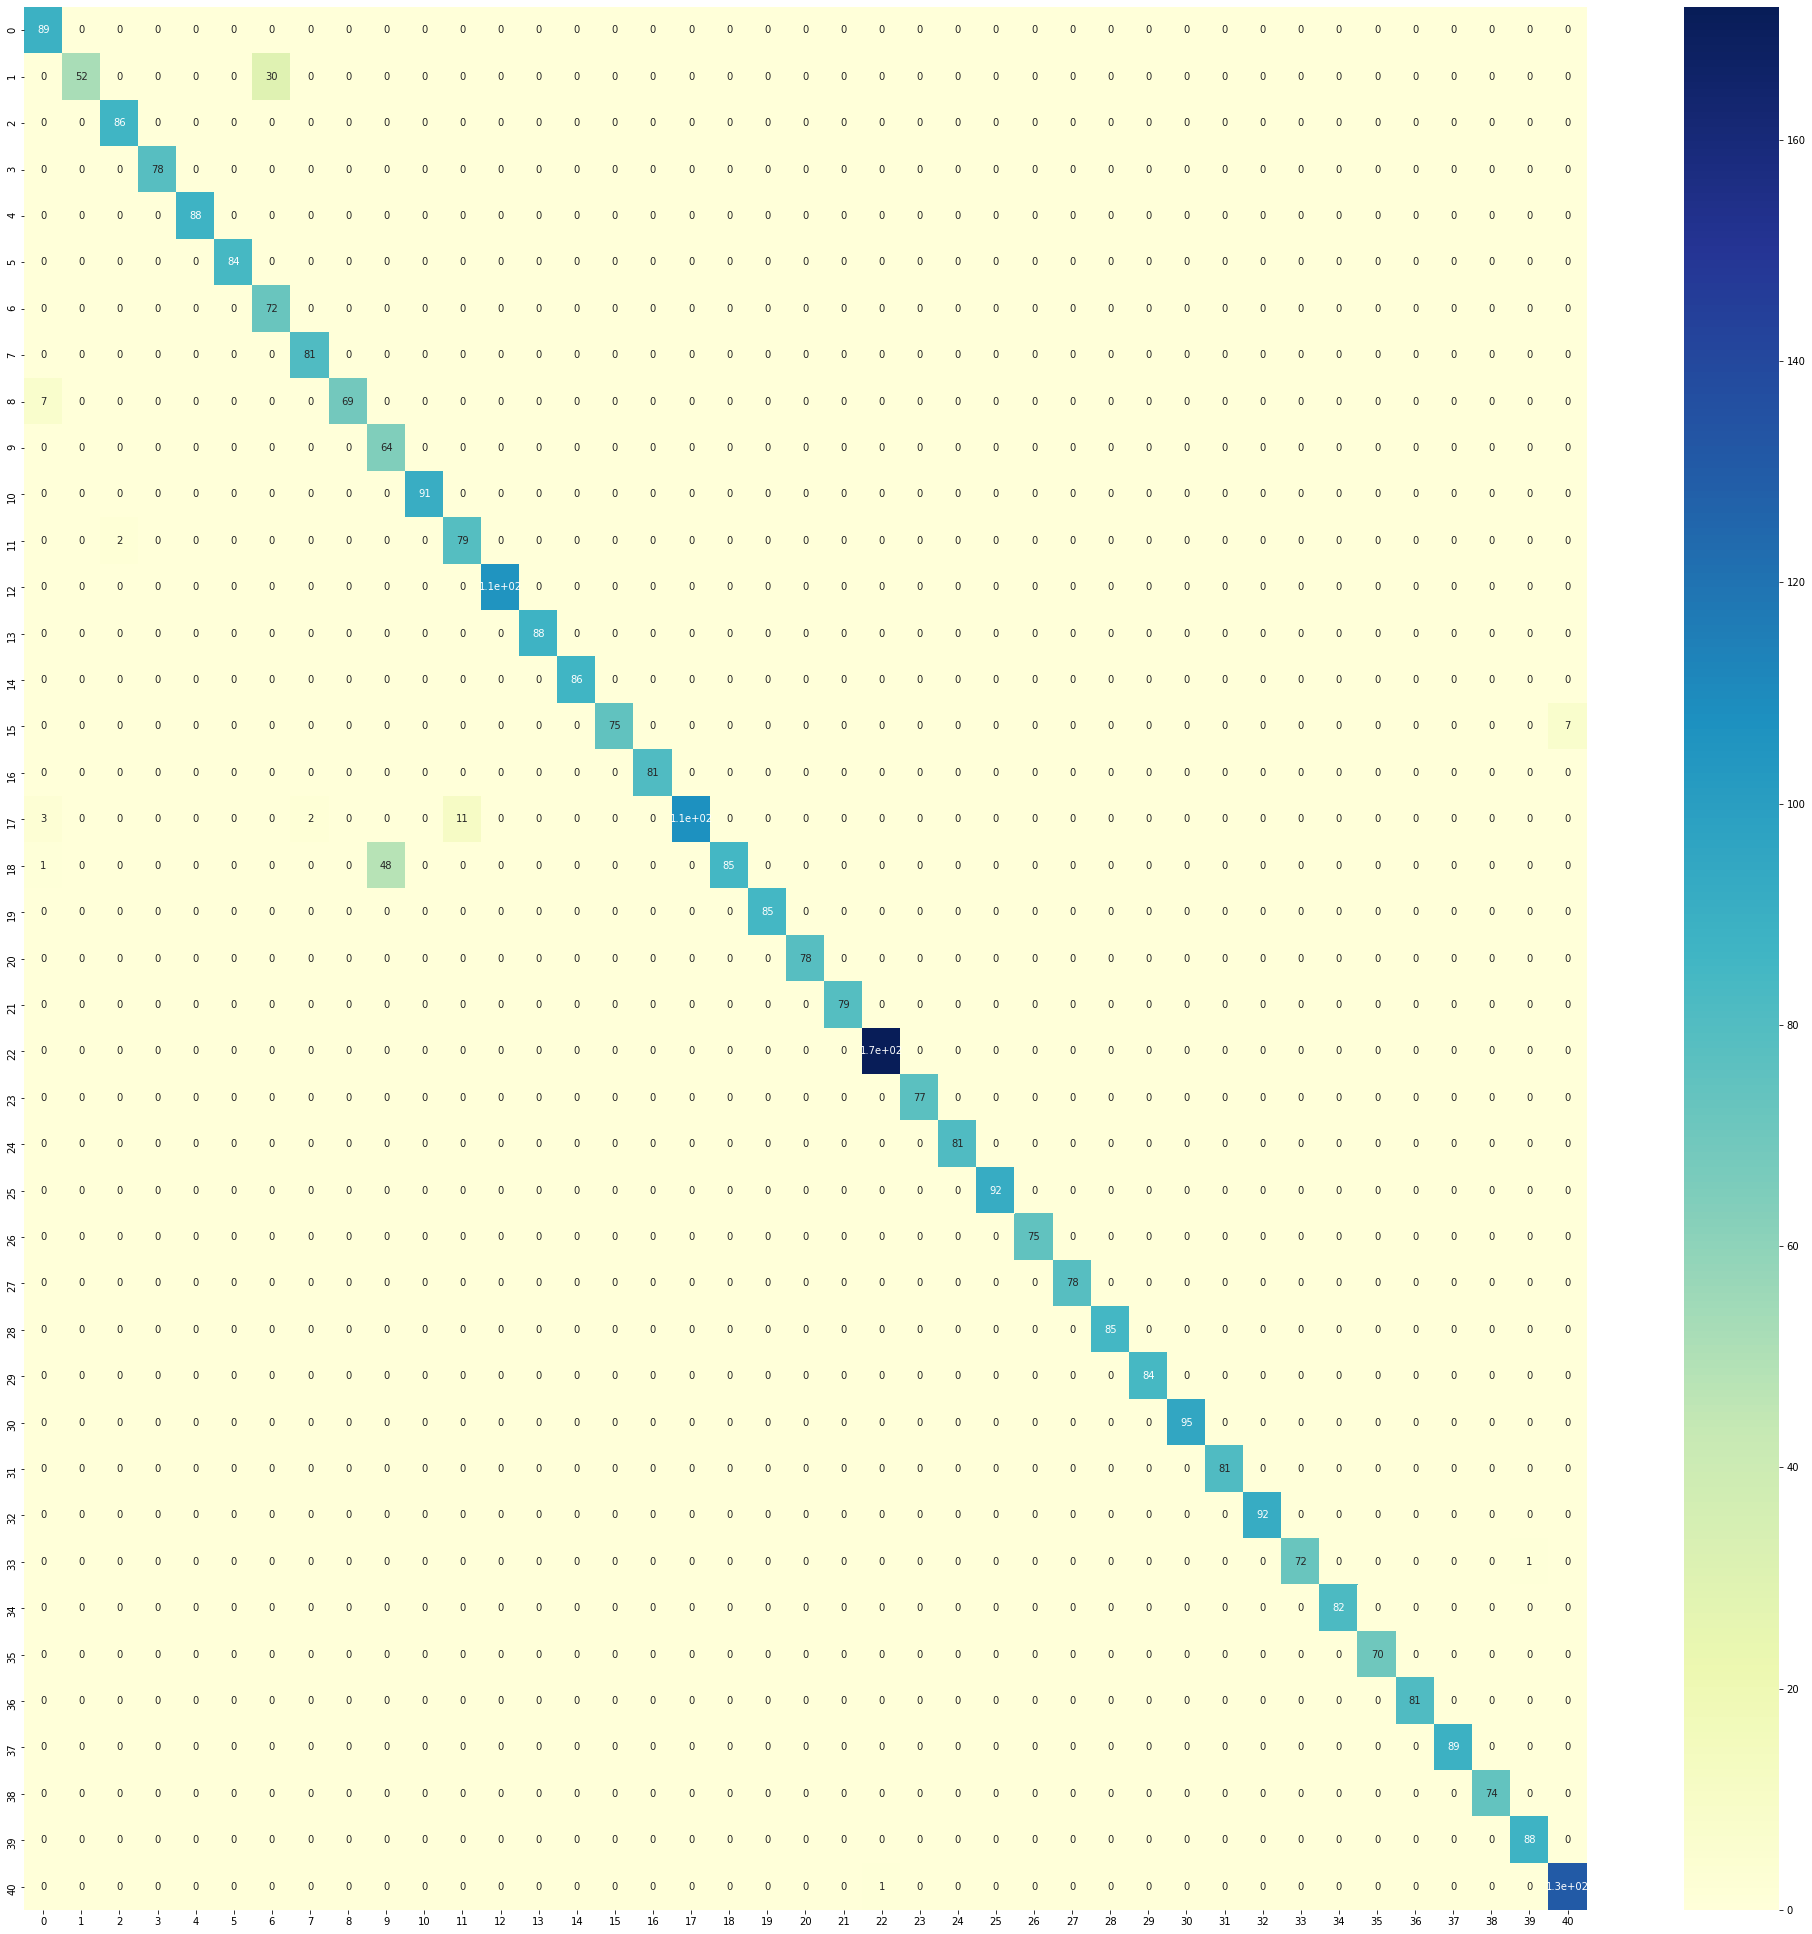

In [26]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = [i for i in range(41)],
                  columns = [i for i in range(41)])
plt.figure(figsize = (35,35))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu")

In [23]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
classification=metrics.classification_report(y_test,preds)
print(classification)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        89
           1       1.00      0.63      0.78        82
           2       0.98      1.00      0.99        86
           3       1.00      1.00      1.00        78
           4       1.00      1.00      1.00        88
           5       1.00      1.00      1.00        84
           6       0.71      1.00      0.83        72
           7       0.98      1.00      0.99        81
           8       1.00      0.91      0.95        76
           9       0.57      1.00      0.73        64
          10       1.00      1.00      1.00        91
          11       0.88      0.98      0.92        81
          12       1.00      1.00      1.00       106
          13       1.00      1.00      1.00        88
          14       1.00      1.00      1.00        86
          15       1.00      0.91      0.96        82
          16       1.00      1.00      1.00        81
          17       1.00    

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
from sklearn import metrics
metrics.roc_auc_score(y_test, preds,multi_class="ovr",average='weighted')

0.9840472550830064